# Knowledge graph experiment data generation

In [1]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import trange

In [15]:
n_nodes = 10
n_relations = 5

node_vocab = [f'N{i}' for i in range(n_nodes)]
relation_vocab = [f'R{i}' for i in range(n_relations)]
special_tokens = ['<CTX>', '</CTX>', '<SEP>', '<QUERY>', '</QUERY>', '<EOS>', '<PAD>', '<UNK>']
vocab = node_vocab + relation_vocab + special_tokens
vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}

In [16]:
# randomly generate a graph

# graph parameters
radiuses = [0.2]* n_relations
dims = [2] * n_relations # 2 for now to make it easy to visualize

# generate graph for each relation
# i'm using random geometric graph for now
# roughly, my thinking is that this may correspond to some more "interesting" type of relation which encodes a transitivity property
# we can think about generating this in different ways later
graphs = [nx.random_geometric_graph(n=node_vocab, radius=radiuses[i], dim=dims[i], p=2) for i in range(n_relations)]

# we transform to a DAG

def to_directed(graph):
    graph = graph.to_directed()

    def violate_direction(edge):
        a = int(edge[0][1:])
        b = int(edge[1][1:])
        return a >= b
    edges_to_remove = [edge for edge in graph.edges if violate_direction(edge)]

    graph.remove_edges_from(edges_to_remove )

    return graph

graphs = [to_directed(graph) for graph in graphs]


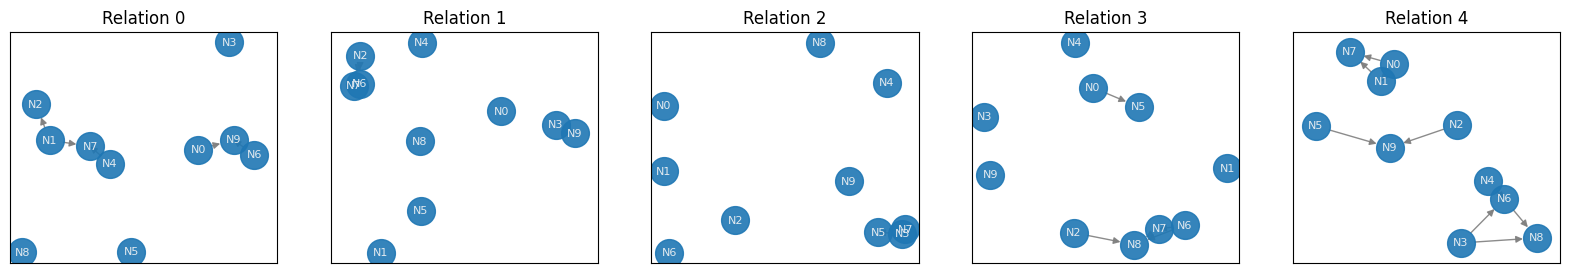

In [17]:
rel = 0

# visualize graphs
fig, axs = plt.subplots(ncols=n_relations, figsize=(4*n_relations,3))
options = {"edge_color": "tab:gray", "node_size": 400, "alpha": 0.9, "node_color": "tab:blue", "font_color": "whitesmoke", "font_size": 8}
for rel in range(n_relations):
    pos = nx.get_node_attributes(graphs[rel], 'pos')
    nx.draw_networkx(graphs[rel], pos=pos, **options, ax=axs[rel])
    axs[rel].set_title(f"Relation {rel}");

In [37]:
facts = {rel: list(graphs[rel].edges) for rel in range(n_relations)}
facts_all = [[fact[0], f'R{rel}', fact[1]] for rel in facts for fact in facts[rel]]

    

# generate context of true but irrelevant facts
def generate_pure_fact_example(fact, return_idx=True):
    # first sample fact for query
    ctx_start = '<CTX>' if not return_idx else vocab_to_idx['<CTX>']
    ctx_end = '</CTX>' if not return_idx else vocab_to_idx['</CTX>']
    query_start = '<QUERY>' if not return_idx else vocab_to_idx['<QUERY>']
    query_end = '</QUERY>' if not return_idx else vocab_to_idx['</QUERY>']
    eos = '<EOS>' if not return_idx else vocab_to_idx['<EOS>']
    fact = [vocab_to_idx[word] for word in fact] if return_idx else fact

    sequence = [ctx_start]

    sequence += [ctx_end, query_start]
    sequence += fact
    sequence += [query_end, eos]

    if not return_idx:
        return ' '.join(sequence)

    return sequence

print(generate_pure_fact_example(facts_all[0], False))
facts_all = [generate_pure_fact_example(fact, True) for fact in facts_all]
print("Number of tota facts:", len(facts_all))
facts_all

<CTX> </CTX> <QUERY> N0 R0 N9 </QUERY> <EOS>
Number of tota facts: 26


[[15, 16, 18, 0, 10, 9, 19, 20],
 [15, 16, 18, 1, 10, 2, 19, 20],
 [15, 16, 18, 1, 10, 7, 19, 20],
 [15, 16, 18, 4, 10, 7, 19, 20],
 [15, 16, 18, 6, 10, 9, 19, 20],
 [15, 16, 18, 2, 11, 6, 19, 20],
 [15, 16, 18, 2, 11, 7, 19, 20],
 [15, 16, 18, 3, 11, 9, 19, 20],
 [15, 16, 18, 6, 11, 7, 19, 20],
 [15, 16, 18, 3, 12, 5, 19, 20],
 [15, 16, 18, 3, 12, 7, 19, 20],
 [15, 16, 18, 5, 12, 7, 19, 20],
 [15, 16, 18, 0, 13, 5, 19, 20],
 [15, 16, 18, 2, 13, 8, 19, 20],
 [15, 16, 18, 6, 13, 7, 19, 20],
 [15, 16, 18, 6, 13, 8, 19, 20],
 [15, 16, 18, 7, 13, 8, 19, 20],
 [15, 16, 18, 0, 14, 1, 19, 20],
 [15, 16, 18, 0, 14, 7, 19, 20],
 [15, 16, 18, 1, 14, 7, 19, 20],
 [15, 16, 18, 2, 14, 9, 19, 20],
 [15, 16, 18, 3, 14, 6, 19, 20],
 [15, 16, 18, 3, 14, 8, 19, 20],
 [15, 16, 18, 4, 14, 6, 19, 20],
 [15, 16, 18, 5, 14, 9, 19, 20],
 [15, 16, 18, 6, 14, 8, 19, 20]]

In [38]:
def sample_fact(return_idx=False):
    # sample relation
    rel = np.random.randint(n_relations)
    # sample fact
    fact_idx = np.random.choice(len(facts[rel]))
    fact = facts[rel][fact_idx]
    n1, n2 = fact
    if return_idx:
        return [vocab_to_idx[n1], vocab_to_idx[f'R{rel}'], vocab_to_idx[n2]]

    return [n1, f'R{rel}', n2]

def sample_falsehood(return_idx=False):
    # sample relation
    rel = np.random.randint(n_relations)

    while True:
        # sample falsehood
        n1, n2 = np.random.choice(node_vocab, size=2)
        if (n1, n2) not in facts[rel]:
            break

    if return_idx:
        return [vocab_to_idx[n1], vocab_to_idx[f'R{rel}'], vocab_to_idx[n2]]

    return [n1, f'R{rel}', n2]


In [39]:
# generate context of true but irrelevant facts
def generate_robustness_example(context_length, return_idx=False):
    # first sample fact for query
    ctx_start = '<CTX>' if not return_idx else vocab_to_idx['<CTX>']
    ctx_end = '</CTX>' if not return_idx else vocab_to_idx['</CTX>']
    sep = '<SEP>' if not return_idx else vocab_to_idx['<SEP>']
    query_start = '<QUERY>' if not return_idx else vocab_to_idx['<QUERY>']
    query_end = '</QUERY>' if not return_idx else vocab_to_idx['</QUERY>']
    eos = '<EOS>' if not return_idx else vocab_to_idx['<EOS>']

    sequence = [ctx_start]

    query_fact = sample_fact(return_idx=return_idx)

    for i in range(context_length):
        # NOTE: for now, not checking if irrelevant; sampling randomly so most likely irrelevant
        ctx_fact = sample_fact(return_idx=return_idx)
        sequence += ctx_fact
        sequence += [sep]

    sequence += [ctx_end, query_start]

    sequence += query_fact
    sequence += [query_end, eos]

    if not return_idx:
        return ' '.join(sequence)

    return sequence


In [40]:
# print some examples of robustness examples
for _ in range(5):
    print(generate_robustness_example(3, return_idx=False))

<CTX> N2 R1 N6 <SEP> N5 R2 N7 <SEP> N5 R2 N7 <SEP> </CTX> <QUERY> N2 R3 N8 </QUERY> <EOS>
<CTX> N4 R4 N6 <SEP> N3 R2 N7 <SEP> N2 R1 N6 <SEP> </CTX> <QUERY> N1 R0 N2 </QUERY> <EOS>
<CTX> N6 R0 N9 <SEP> N0 R4 N1 <SEP> N3 R2 N5 <SEP> </CTX> <QUERY> N6 R3 N7 </QUERY> <EOS>
<CTX> N3 R2 N5 <SEP> N3 R2 N7 <SEP> N3 R4 N6 <SEP> </CTX> <QUERY> N5 R2 N7 </QUERY> <EOS>
<CTX> N6 R0 N9 <SEP> N1 R0 N2 <SEP> N2 R1 N6 <SEP> </CTX> <QUERY> N3 R1 N9 </QUERY> <EOS>


In [41]:
# query is inconsistent with world knowledge
def generate_controllability_example(context_length, insert_pos=None, return_idx=False):
    # first sample fact for query
    ctx_start = '<CTX>' if not return_idx else vocab_to_idx['<CTX>']
    ctx_end = '</CTX>' if not return_idx else vocab_to_idx['</CTX>']
    sep = '<SEP>' if not return_idx else vocab_to_idx['<SEP>']
    query_start = '<QUERY>' if not return_idx else vocab_to_idx['<QUERY>']
    query_end = '</QUERY>' if not return_idx else vocab_to_idx['</QUERY>']
    eos = '<EOS>' if not return_idx else vocab_to_idx['<EOS>']

    sequence = [ctx_start]

    query_fact = sample_falsehood(return_idx=return_idx)

    contexts = []
    for i in range(context_length-1):
        ctx_fact = sample_fact(return_idx=return_idx)
        contexts.append(ctx_fact)

    # insert query fact at random position of context to test controllability
    if insert_pos is None:
        insert_pos = np.random.randint(context_length)
    contexts.insert(insert_pos, query_fact)

    for ctx_fact in contexts:
        sequence += ctx_fact
        sequence += [sep]

    sequence += [ctx_end, query_start]

    sequence += query_fact
    sequence += [query_end, eos]

    if not return_idx:
        return ' '.join(sequence)

    return sequence


In [42]:
# print some examples of robustness examples
for _ in range(5):
    print(generate_controllability_example(3, return_idx=False))

<CTX> N5 R2 N7 <SEP> N1 R0 N2 <SEP> N2 R1 N5 <SEP> </CTX> <QUERY> N2 R1 N5 </QUERY> <EOS>
<CTX> N5 R0 N7 <SEP> N2 R1 N6 <SEP> N3 R2 N7 <SEP> </CTX> <QUERY> N5 R0 N7 </QUERY> <EOS>
<CTX> N3 R1 N9 <SEP> N2 R1 N0 <SEP> N6 R4 N8 <SEP> </CTX> <QUERY> N2 R1 N0 </QUERY> <EOS>
<CTX> N0 R0 N9 <SEP> N3 R4 N6 <SEP> N2 R2 N4 <SEP> </CTX> <QUERY> N2 R2 N4 </QUERY> <EOS>
<CTX> N1 R4 N7 <SEP> N5 R0 N9 <SEP> N6 R3 N7 <SEP> </CTX> <QUERY> N5 R0 N9 </QUERY> <EOS>


In [43]:
# print some examples of robustness examples (print token idx)
for _ in range(5):
    print(generate_controllability_example(3, return_idx=True))

[15, 8, 12, 4, 17, 0, 14, 7, 17, 5, 12, 7, 17, 16, 18, 8, 12, 4, 19, 20]
[15, 2, 13, 8, 17, 9, 11, 3, 17, 1, 10, 7, 17, 16, 18, 9, 11, 3, 19, 20]
[15, 9, 14, 1, 17, 2, 11, 7, 17, 1, 10, 2, 17, 16, 18, 9, 14, 1, 19, 20]
[15, 1, 10, 7, 17, 1, 11, 3, 17, 5, 12, 7, 17, 16, 18, 1, 11, 3, 19, 20]
[15, 0, 13, 5, 17, 3, 10, 1, 17, 6, 13, 8, 17, 16, 18, 3, 10, 1, 19, 20]


In [12]:
# pre-training: "robustness" context_length=0

# training
# w.p. 1/3
# just facts: "robustness" with context_length=0
# w.p. 1/3
# robustness: uniformly context_length=1,2,3
# w.p. 1/3
# controllability: uniformly context_length=1,2,3

# validation
# same but separate context_lengths to different datasets to compute separate metrics

In [44]:
def pad_truncate(sequence, max_length):
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    elif len(sequence) < max_length:
        sequence += [vocab_to_idx['<PAD>']] * (max_length - len(sequence))

    return sequence

## Create training dataset

In [54]:
# create train_ds
n_examples = 3000 # total number of examples

p_facts = 1/3 # proportion of facts
p_robustness = 1/3 # proportion of robustness
p_controllability = 1/3 # proportion of controllability
assert (p_facts + p_robustness + p_controllability) == 1 # make sure this makes sense

max_context_statements = 3 # maximum number of context facts; sample uniformly from 1,2,3
max_block_length = len(generate_robustness_example(3, return_idx=True)) # get the block length of the longest example

n_facts = int(n_examples * p_facts)
n_robustness = int(n_examples * p_robustness)
n_controllability = int(n_examples * p_controllability)

In [55]:
# create pure fact train_ds_fact for pretraining
max_length = len(facts_all[0]) # get the block length of the longest example

train_data_fact = [pad_truncate(fact, max_length) for fact in facts_all]
train_data_fact

[[15, 16, 18, 0, 10, 9, 19, 20],
 [15, 16, 18, 1, 10, 2, 19, 20],
 [15, 16, 18, 1, 10, 7, 19, 20],
 [15, 16, 18, 4, 10, 7, 19, 20],
 [15, 16, 18, 6, 10, 9, 19, 20],
 [15, 16, 18, 2, 11, 6, 19, 20],
 [15, 16, 18, 2, 11, 7, 19, 20],
 [15, 16, 18, 3, 11, 9, 19, 20],
 [15, 16, 18, 6, 11, 7, 19, 20],
 [15, 16, 18, 3, 12, 5, 19, 20],
 [15, 16, 18, 3, 12, 7, 19, 20],
 [15, 16, 18, 5, 12, 7, 19, 20],
 [15, 16, 18, 0, 13, 5, 19, 20],
 [15, 16, 18, 2, 13, 8, 19, 20],
 [15, 16, 18, 6, 13, 7, 19, 20],
 [15, 16, 18, 6, 13, 8, 19, 20],
 [15, 16, 18, 7, 13, 8, 19, 20],
 [15, 16, 18, 0, 14, 1, 19, 20],
 [15, 16, 18, 0, 14, 7, 19, 20],
 [15, 16, 18, 1, 14, 7, 19, 20],
 [15, 16, 18, 2, 14, 9, 19, 20],
 [15, 16, 18, 3, 14, 6, 19, 20],
 [15, 16, 18, 3, 14, 8, 19, 20],
 [15, 16, 18, 4, 14, 6, 19, 20],
 [15, 16, 18, 5, 14, 9, 19, 20],
 [15, 16, 18, 6, 14, 8, 19, 20]]

In [56]:
train_data = []

for _ in trange(n_facts):
    example = generate_robustness_example(0, return_idx=True)
    example = pad_truncate(example, max_block_length)
    train_data.append(example)

for _ in trange(n_robustness):
    n_context_statements = np.random.randint(1, max_context_statements+1)
    example = generate_robustness_example(n_context_statements, return_idx=True)
    example = pad_truncate(example, max_block_length)
    train_data.append(example)

for _ in trange(n_controllability):
    n_context_statements = np.random.randint(1, max_context_statements+1)
    insert_pos = np.random.randint(n_context_statements)
    example = generate_controllability_example(n_context_statements, insert_pos=insert_pos, return_idx=True)
    example = pad_truncate(example, max_block_length)
    train_data.append(example)


100%|██████████| 1000/1000 [00:00<00:00, 34795.95it/s]


100%|██████████| 1000/1000 [00:00<00:00, 20568.88it/s]


In [57]:
# create and save
train_ds_tensor = torch.tensor(train_data, dtype=torch.int64)
# np.random.shuffle(train_ds)
torch.save(train_ds_tensor, '../data/knowledge_graph/knowledge_graph_train_ds.pt')

train_ds_fact_tensor = torch.tensor(train_data_fact, dtype=torch.int64)
torch.save(train_ds_fact_tensor, '../data/knowledge_graph/knowledge_graph_train_ds_fact.pt')

In [58]:
train_ds_tensor = torch.load('../data/knowledge_graph/knowledge_graph_train_ds.pt')
train_ds_fact_tensor = torch.load('../data/knowledge_graph/knowledge_graph_train_ds_fact.pt')

In [52]:
def generate_val_data(type, n_context_statements, n_examples, max_block_length=max_block_length):
    example_generator = generate_robustness_example if type == 'robustness' else generate_controllability_example
    val_data = []
    for _ in trange(n_examples):
        example = example_generator(n_context_statements, return_idx=True)
        example = pad_truncate(example, max_block_length)
        val_data.append(example)

    return torch.tensor(val_data)


In [31]:
for type in ['robustness', 'controllability']:
    for n_context_statements in range(1, max_context_statements+1):
        n_examples = 1_000
        val_data = generate_val_data(type, n_context_statements, n_examples)
        torch.save(val_data, f'../data/knowledge_graph/knowledge_graph_val_ds_{type}_{n_context_statements}.pt')

100%|██████████| 1000/1000 [00:00<00:00, 16085.72it/s]


### Demo on how to load data

In [32]:
# how to load data and createe data loader
import sys; sys.path.append('../')
from data_utils import LanguageModelTensorDataset
train_ds = LanguageModelTensorDataset(train_ds_tensor)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True)

In [59]:
# some examples from train_ds_tensor
for x in train_ds_tensor[:50]:
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    print()

[15, 16, 18, 3, 12, 5, 19, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
<CTX> </CTX> <QUERY> N3 R2 N5 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[15, 16, 18, 1, 10, 7, 19, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
<CTX> </CTX> <QUERY> N1 R0 N7 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[15, 16, 18, 2, 11, 7, 19, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
<CTX> </CTX> <QUERY> N2 R1 N7 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[15, 16, 18, 3, 12, 5, 19, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
<CTX> </CTX> <QUERY> N3 R2 N5 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[15, 16, 18, 5, 12, 7, 19, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
<CTX> </CTX> <QUERY> N5 R2 N7 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

[15, 16, 18, 6,

In [60]:
# some examples from train__ds_tensor
for x in train_ds_fact_tensor[:5]:
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    print()

[15, 16, 18, 0, 10, 9, 19, 20]
<CTX> </CTX> <QUERY> N0 R0 N9 </QUERY> <EOS>

[15, 16, 18, 1, 10, 2, 19, 20]
<CTX> </CTX> <QUERY> N1 R0 N2 </QUERY> <EOS>

[15, 16, 18, 1, 10, 7, 19, 20]
<CTX> </CTX> <QUERY> N1 R0 N7 </QUERY> <EOS>

[15, 16, 18, 4, 10, 7, 19, 20]
<CTX> </CTX> <QUERY> N4 R0 N7 </QUERY> <EOS>

[15, 16, 18, 6, 10, 9, 19, 20]
<CTX> </CTX> <QUERY> N6 R0 N9 </QUERY> <EOS>



In [22]:
# some examples from train_dl
train_iter = iter(train_dl)
for _ in range(5):
    # get next from train_dl
    x, y = next(train_iter)
    x, y = x.squeeze(), y.squeeze()
    print('INPUT')
    print(x.tolist())
    print(' '.join([vocab[idx] for idx in x]))
    print('TARGET')
    print(y.tolist())
    print(' '.join([vocab[idx] for idx in y]))
    print('-'*100)
    print()

(tensor([55, 56, 58,  4, 52,  9, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
        61]), tensor([56, 58,  4, 52,  9, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
        61]))
INPUT
[55, 56, 58, 34, 54, 46, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
<CTX> </CTX> <QUERY> N34 R4 N46 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
TARGET
[56, 58, 34, 54, 46, 59, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]
</CTX> <QUERY> N34 R4 N46 </QUERY> <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
----------------------------------------------------------------------------------------------------

INPUT
[55, 32, 52, 35, 57, 11, 51, 20, 57, 27, 54, 46, 57, 56, 58, 1, 53, 49, 59]
<CTX> N32 R2 N35 <SEP> N11 R1 N20 <SEP> N27 R4 N46 <SEP> </CTX> <QUERY> N1 R3 N49 </QUERY>
TARGET
[32, 52, 35, 57, 11, 51, 20, 57, 27, 54, 46, 57, 56, 58, 1, 53, 49, 59, 60]
N32 R2 N35 <SEP> N11 R1 N20 <SEP> N27 R4 N46 <SEP> </CTX> <Q